In [1]:
# Standard library imports.
from datetime import datetime, timedelta

# Related third party imports.
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,8)

# Local application/library specific imports.


# Download link traffic between firstDay and lastDay
# tuple, datetime, datetime -> ('bost-cr5','2/1/1'), datetime(2016,1,1,0,0,30), datetime(2016,2,1,0,0,0)
def download_link_traffic(link: tuple, start_date: datetime,
                          end_date: datetime) -> pd.DataFrame:
    # Empty list for the data
    traffic_data = []

    current_date = start_date
    while current_date < end_date:
        # The URL contains the link and time info.
        url = 'https://my.es.net/graphql?query={query:interface(device:"' + str(
            link[0]) + '",interface:"' + str(
                link[1]) + '"){traffic(beginTime:"' + current_date.isoformat(
                ) + '" endTime:"' + (current_date + timedelta(days=1)
                                     ).isoformat() + '"){points}}}&raw'

        # Downloading the data
        data = requests.get(url, verify=False)
        # Converting it to JSON
        json_data = data.json()

        if json_data['data']['query']['traffic']:
            # We have to go down some levels to get the data.
            # -> json_data['data']['query']['traffic']['points']
            traffic_data.extend(
                json_data['data']['query']['traffic']['points'])

        #moving to the next day
        current_date = current_date + timedelta(days=1)
    return pd.DataFrame(traffic_data, columns=['date', 'in', 'out'])

def changeDateFormat(df):
    # Oneliner to convert the UNIX timestamp to readable format
    func = lambda x: datetime.utcfromtimestamp(int(x)/1000).strftime('%Y-%m-%d %H:%M:%S')
    # Exchanging the timestamps
    df['date'] = df['date'].apply(func)
    return df

In [2]:
# Test the traffic download...
link = ("amst-cr5", "4/1/1")
a, b = datetime(2021,9,1,0,0,30), datetime(2021,11,19,0,0,0)
df = download_link_traffic(link, a, b)
df = changeDateFormat(df)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

KeyboardInterrupt: ignored

In [ ]:
df['in'].fillna(np.mean(df['in']), inplace=True)
df['out'].fillna(np.mean(df['out']), inplace=True)
df['in'] = df['in']/10**9
df['out'] = df['out']/10**9

In [ ]:
df_out = df['out']
df_in = df['in']

dataset = df['in']
#dataset = dataset[:20000]

In [ ]:
df

,date,in,out
0,2021-09-28 18:54:00,0.455989,0.726722
1,2021-09-28 18:56:00,0.838383,0.602138
2,2021-09-28 18:58:00,0.965994,0.409081
3,2021-09-28 19:00:00,2.919324,0.150225
4,2021-09-28 19:02:00,4.725088,0.171992
...,...,...,...
36920,2021-11-18 23:52:00,0.527621,2.790950
36921,2021-11-18 23:54:00,0.678641,2.382109
36922,2021-11-18 23:56:00,0.623023,2.161135
36923,2021-11-18 23:58:00,0.756997,1.586033


In [ ]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(dataset, test_size=0.1, shuffle=False)

In [ ]:
training_set = dataset_train.values
training_set = np.reshape(training_set, (-1, 1))

In [ ]:
X_train = []
y_train = []
WINDOW_SIZE = 5

for i in range(WINDOW_SIZE,len(training_set)):
  X_train.append(training_set[i-WINDOW_SIZE:i, 0])
  y_train.append(training_set[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
import keras
import keras.models
import keras.layers

model = keras.models.Sequential([
    keras.layers.LSTM(60, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(60, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(60),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=2)
model.fit(X_train, y_train, epochs = 120, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/120
450/450 [==============================] - 13s 17ms/step - loss: 17.1581 - val_loss: 4.4863
Epoch 2/120
450/450 [==============================] - 6s 14ms/step - loss: 3.0843 - val_loss: 2.7386
Epoch 3/120
450/450 [==============================] - 7s 15ms/step - loss: 2.4165 - val_loss: 1.7028
Epoch 4/120
450/450 [==============================] - 7s 14ms/step - loss: 2.1149 - val_loss: 1.5572
Epoch 5/120
450/450 [==============================] - 7s 15ms/step - loss: 2.0892 - val_loss: 1.4858
Epoch 6/120
450/450 [==============================] - 6s 14ms/step - loss: 1.9373 - val_loss: 1.3403
Epoch 7/120
450/450 [==============================] - 7s 15ms/step - loss: 1.9316 - val_loss: 1.5004
Epoch 8/120
450/450 [==============================] - 7s 14ms/step - loss: 1.9128 - val_loss: 1.2987
Epoch 9/120
450/450 [==============================] - 7s 14ms/step - loss: 1.9099 - val_loss: 1.4235
Epoch 10/120
450/450 [==============================] - 6s 14ms/step - loss: 1.8

In [ ]:
test_set = training_set[-WINDOW_SIZE:]
rem_test = dataset_test.values # remaining_test_set
rem_test = np.reshape(rem_test, (-1, 1))
test_set = np.append(test_set, rem_test)
test_set = np.reshape(test_set, (-1, 1))
X_test = []
for i in range(WINDOW_SIZE, len(test_set)):
    X_test.append(test_set[i-WINDOW_SIZE:i, 0])
  
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
predicted_traf = model.predict(X_test)

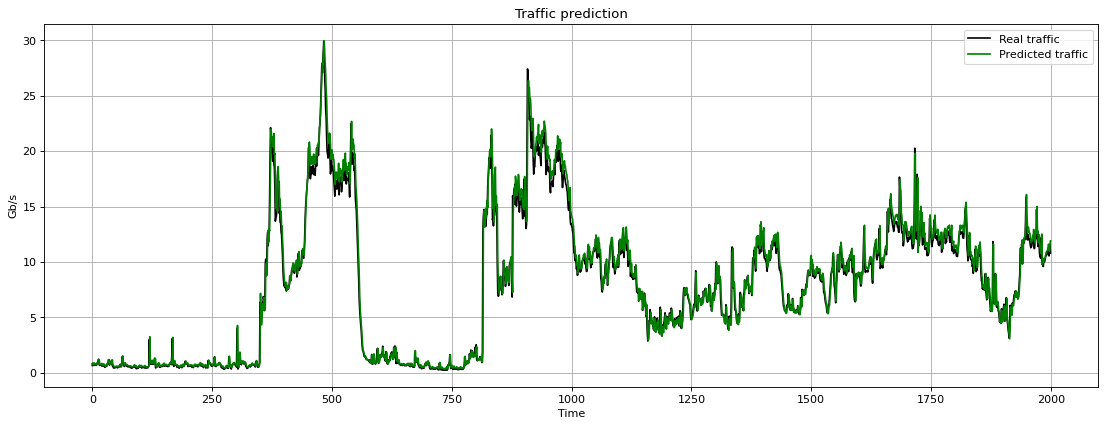

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(17, 6), dpi=80)

plt.plot(rem_test, color = 'black', label = 'Real traffic')
plt.plot(predicted_traf, color = 'green', label = 'Predicted traffic')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(rem_test, predicted_traf)

1.0154904788814594

In [ ]:
diff = (abs(predicted_traf - rem_test)).flatten()
diff

array([0.14376207, 0.11385474, 0.1335966 , ..., 0.12185283, 0.04879   ,
       1.10592557])

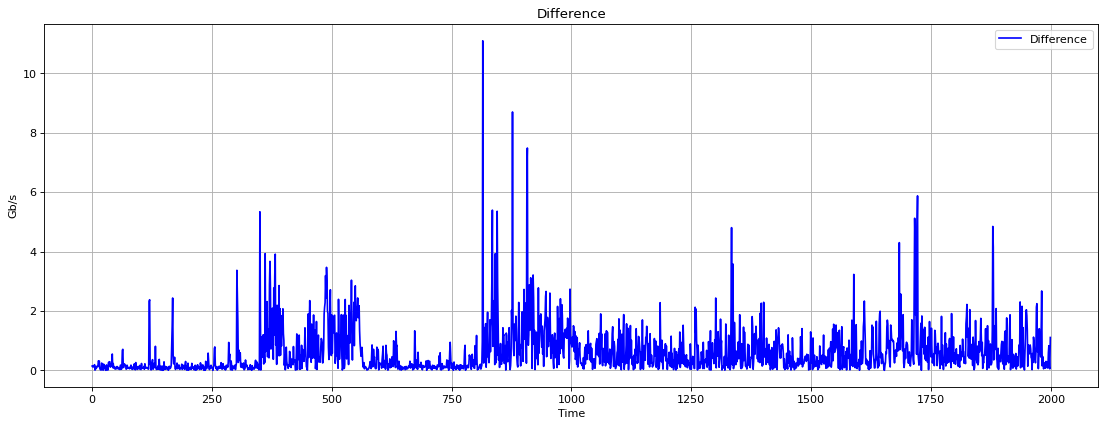

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(17, 6), dpi=80)

plt.plot(diff, color = 'blue', label = 'Difference')
plt.title('Difference')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.grid()
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


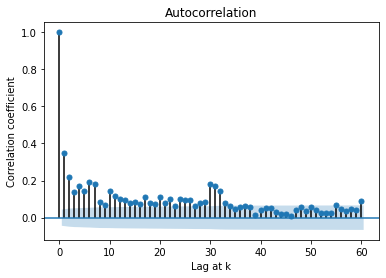

In [ ]:
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(diff, lags=60)
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

**Smoothing**

Moving average

In [ ]:
def moving_avarage_smoothing(X,k):
	S = np.zeros(X.shape[0])
	for t in range(X.shape[0]):
		if t < k:
			S[t] = np.mean(X[:t+1])
		else:
			S[t] = np.sum(X[t-k:t])/k
	return S

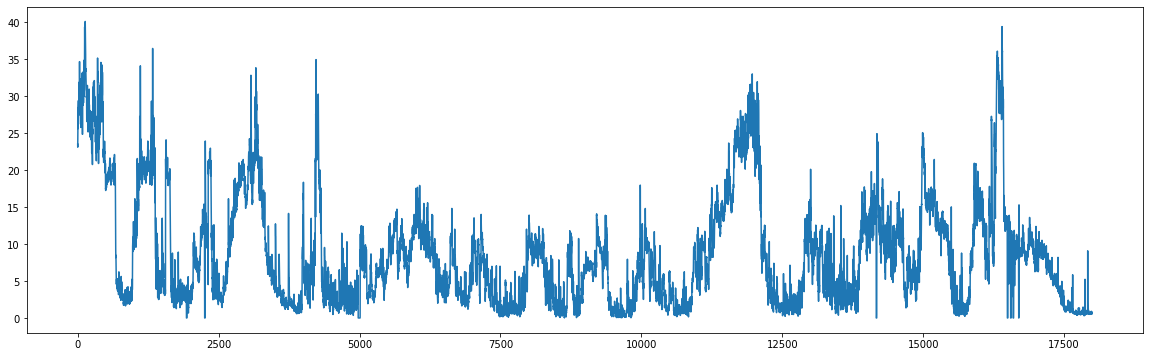

In [ ]:
plt.rcParams["figure.figsize"] = (20,6)
dataset_train.plot()

In [ ]:
smoothened = moving_avarage_smoothing(dataset_train, 80)

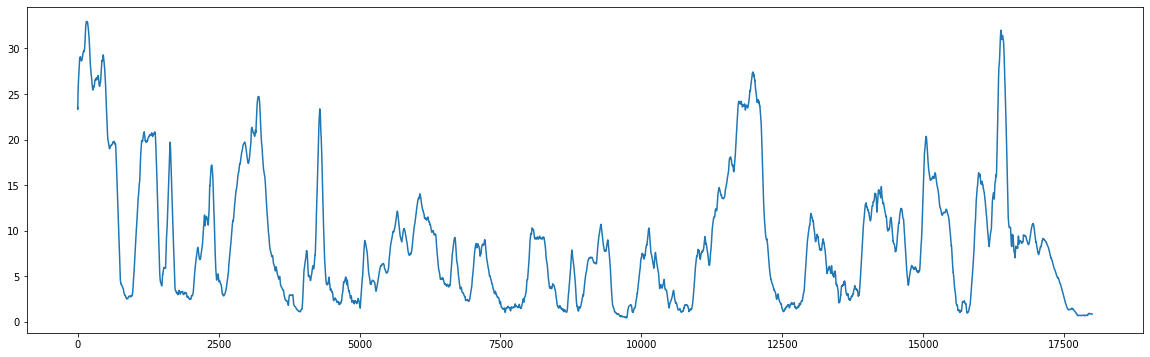

In [ ]:
plt.plot(smoothened)

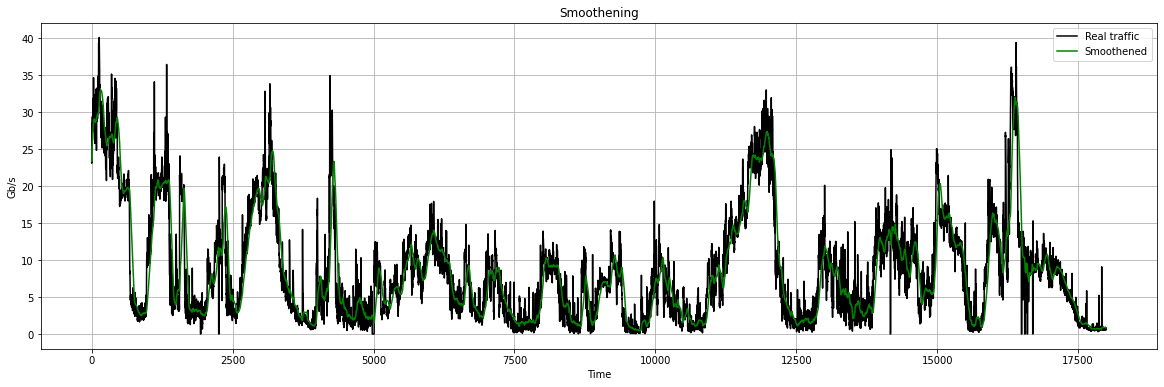

In [ ]:
plt.plot(dataset_train, color = 'black', label = 'Real traffic')
plt.plot(smoothened, color = 'green', label = 'Smoothened')
plt.title('Smoothening')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.grid()
plt.show()

In [ ]:
training_set = smoothened
training_set = np.reshape(training_set, (-1, 1))

In [ ]:
X_train = []
y_train = []
WINDOW_SIZE = 120

for i in range(WINDOW_SIZE,len(training_set)):
  X_train.append(training_set[i-WINDOW_SIZE:i, 0])
  y_train.append(training_set[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
import keras
import keras.models
import keras.layers

model = keras.models.Sequential([
    keras.layers.LSTM(60, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(60),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=6)
model.fit(X_train, y_train, epochs = 120, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/120
447/447 [==============================] - 45s 96ms/step - loss: 11.9846 - val_loss: 2.1168
Epoch 2/120
447/447 [==============================] - 42s 94ms/step - loss: 1.3084 - val_loss: 0.6605
Epoch 3/120
447/447 [==============================] - 42s 94ms/step - loss: 0.8997 - val_loss: 0.3310
Epoch 4/120
447/447 [==============================] - 42s 94ms/step - loss: 0.7338 - val_loss: 0.1823
Epoch 5/120
447/447 [==============================] - 42s 94ms/step - loss: 0.6729 - val_loss: 0.1140
Epoch 6/120
447/447 [==============================] - 42s 94ms/step - loss: 0.6486 - val_loss: 0.1792
Epoch 7/120
447/447 [==============================] - 42s 95ms/step - loss: 0.6377 - val_loss: 0.1254
Epoch 8/120
447/447 [==============================] - 42s 94ms/step - loss: 0.6181 - val_loss: 0.0940
Epoch 9/120
447/447 [==============================] - 42s 94ms/step - loss: 0.5788 - val_loss: 0.0250
Epoch 10/120
447/447 [==============================] - 42s 94ms/step - 

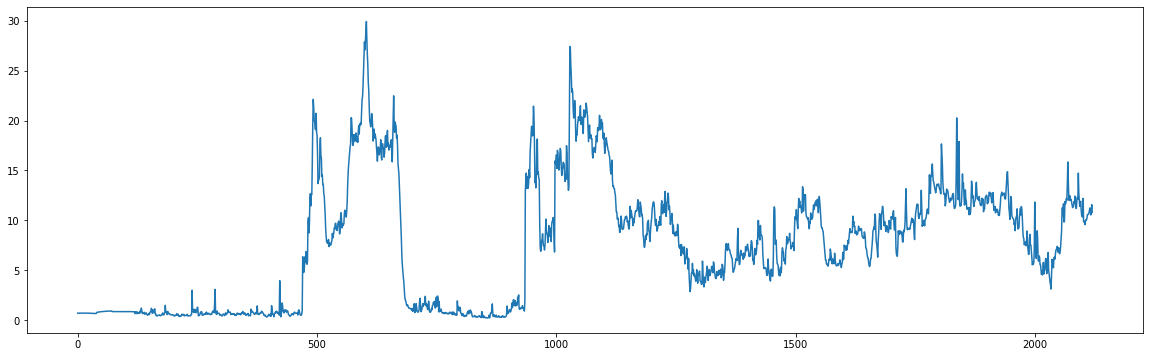

In [ ]:
test_set = training_set[-WINDOW_SIZE:]
rem_test = dataset_test.values # remaining_test_set
rem_test = np.reshape(rem_test, (-1, 1))
test_set = np.append(test_set, rem_test)
#test_set = moving_avarage_smoothing(test_set, 8)
plt.plot(test_set)
test_set = np.reshape(test_set, (-1, 1))
X_test = []
for i in range(WINDOW_SIZE, len(test_set)):
    X_test.append(test_set[i-WINDOW_SIZE:i, 0])
  
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
predicted_traf = model.predict(X_test)

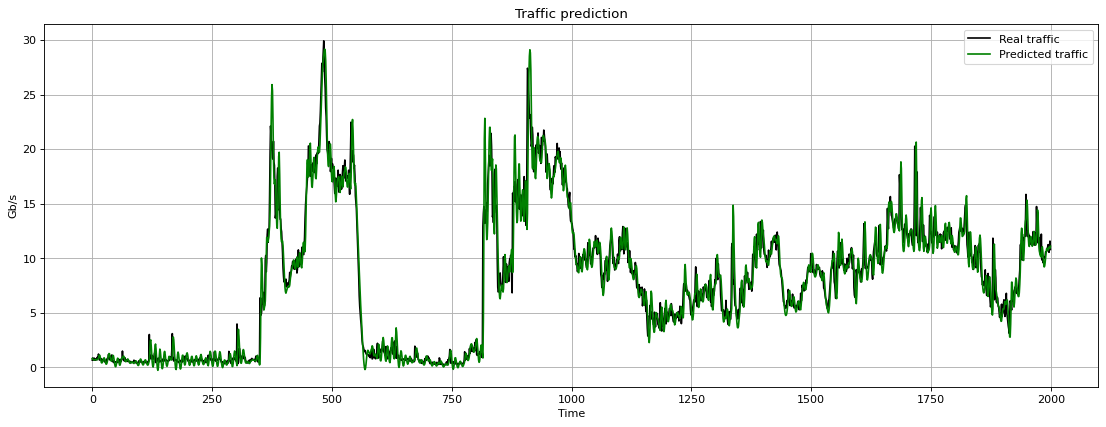

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(17, 6), dpi=80)

plt.plot(rem_test, color = 'black', label = 'Real traffic')
plt.plot(predicted_traf, color = 'green', label = 'Predicted traffic')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(rem_test, predicted_traf)

2.140699562774246

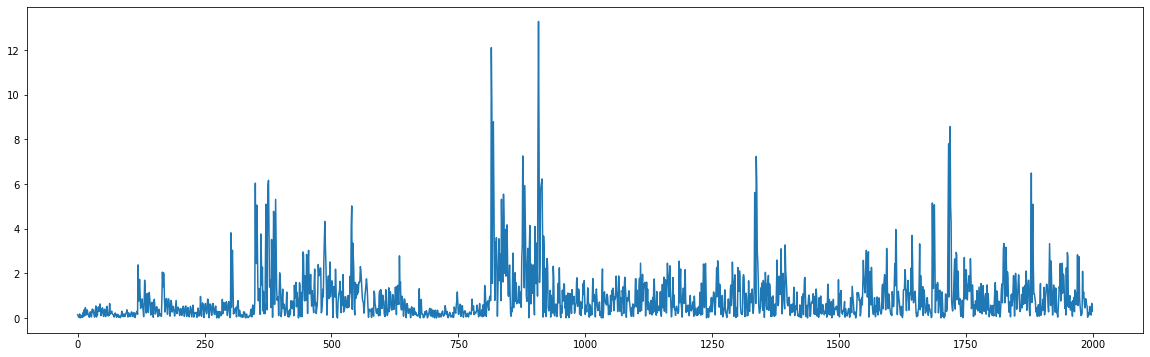

In [ ]:
diff = (abs(predicted_traf - rem_test)).flatten()
plt.plot(diff)

Naive error

In [ ]:
naive_pred = rem_test[:-1]
naive_truth = rem_test[1:]

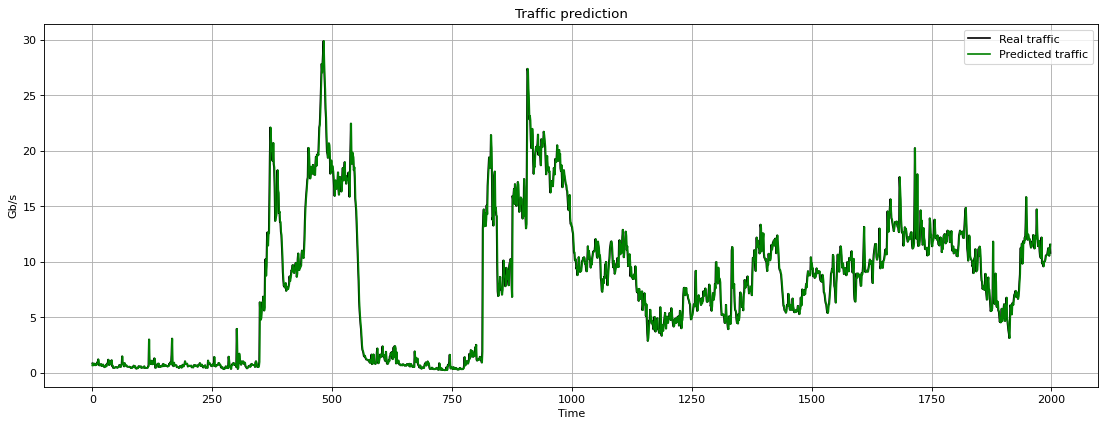

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(17, 6), dpi=80)

plt.plot(naive_truth, color = 'black', label = 'Real traffic')
plt.plot(naive_pred, color = 'green', label = 'Predicted traffic')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.grid()
plt.show()

In [ ]:
mean_squared_error(naive_truth, naive_pred)

0.7998328279378633

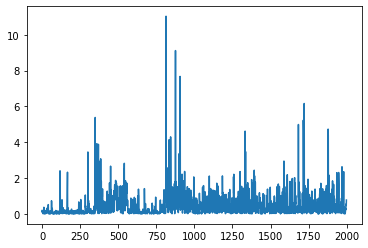

In [ ]:
n_diff = (abs(naive_pred - naive_truth)).flatten()
plt.plot(n_diff)

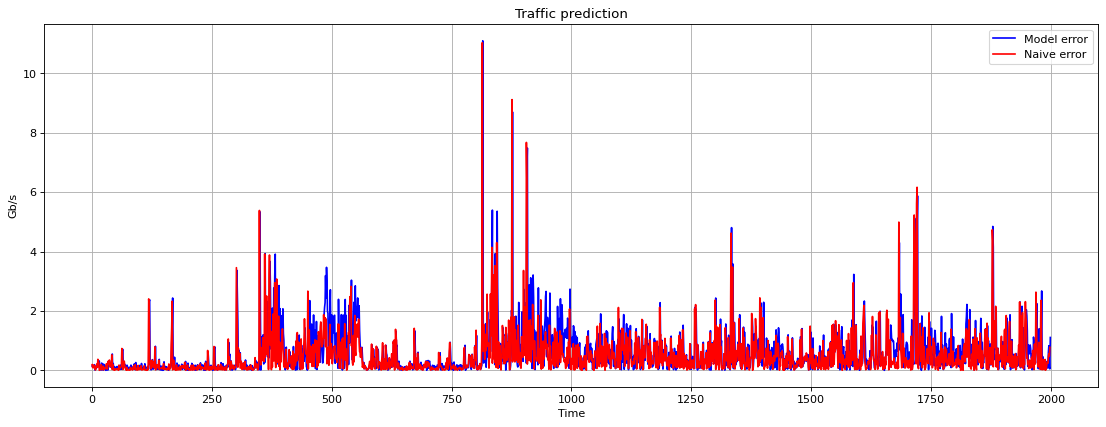

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(17, 6), dpi=80)

plt.plot(diff, color = 'blue', label = 'Model error')
plt.plot(n_diff, color = 'red', label = 'Naive error')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.grid()
plt.show()

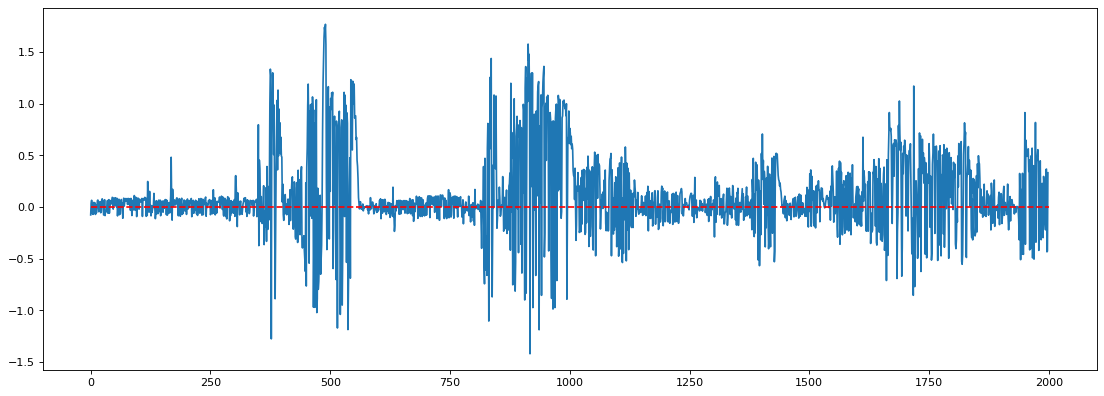

In [ ]:
figure(figsize=(17, 6), dpi=80)

error_diff = diff[1:] - n_diff
plt.plot(error_diff)
plt.plot([0,2000],[0,0], '--', color='red')

In [ ]:
def max_metric(preds, truth, max_boundary = 1):
  if(len(preds) != len(truth)):
    raise Exception('Incompatible input length!')
  
  sum_error = 0
  for i in range(0, len(preds)):
    if(abs(preds[i] - truth[i]) > max_boundary):
      sum_error += max_boundary
    else:
      sum_error += abs(preds[i] - truth[i])
  
  return sum_error / len(preds)

In [ ]:
max_metric(predicted_traf, rem_test,0.8)

array([0.41378372])

In [ ]:
max_metric(naive_pred, naive_truth,0.8)

array([0.36500617])

Ensemble

In [ ]:
import keras
import keras.models
import keras.layers

model1 = keras.models.Sequential([
    keras.layers.LSTM(40, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(40, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(40),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model1.compile(optimizer = 'adam', loss = 'mean_squared_error')

#==========================================================7==

model2 = keras.models.Sequential([
    keras.layers.LSTM(40, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dropout(0.2),
    #keras.layers.LSTM(80, return_sequences=True),
    #keras.layers.Dropout(0.2),
    keras.layers.LSTM(40),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model2.compile(optimizer = 'adam', loss = 'mean_squared_error')

#==========================================================7==

model3 = keras.models.Sequential([
    keras.layers.LSTM(40, return_sequences=True, input_shape=[None, 1]),
    #keras.layers.Dropout(0.2),
    #keras.layers.LSTM(80, return_sequences=True),
    #keras.layers.Dropout(0.2),
    keras.layers.LSTM(40),
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model3.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=6)
model1.fit(X_train, y_train, epochs = 120, validation_split=0.1, callbacks=[early_stopping])
model2.fit(X_train, y_train, epochs = 120, validation_split=0.1, callbacks=[early_stopping])
model3.fit(X_train, y_train, epochs = 120, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/120
507/507 [==============================] - 10s 10ms/step - loss: 23.6420 - val_loss: 11.4679
Epoch 2/120
507/507 [==============================] - 4s 7ms/step - loss: 4.0881 - val_loss: 5.4172
Epoch 3/120
507/507 [==============================] - 4s 8ms/step - loss: 3.0010 - val_loss: 3.3795
Epoch 4/120
507/507 [==============================] - 4s 7ms/step - loss: 2.6536 - val_loss: 2.5726
Epoch 5/120
507/507 [==============================] - 4s 8ms/step - loss: 2.4086 - val_loss: 2.1245
Epoch 6/120
507/507 [==============================] - 4s 8ms/step - loss: 2.3512 - val_loss: 1.9025
Epoch 7/120
507/507 [==============================] - 4s 8ms/step - loss: 2.2853 - val_loss: 1.7938
Epoch 8/120
507/507 [==============================] - 4s 8ms/step - loss: 2.2051 - val_loss: 1.6092
Epoch 9/120
507/507 [==============================] - 4s 7ms/step - loss: 2.1196 - val_loss: 1.5474
Epoch 10/120
507/507 [==============================] - 4s 7ms/step - loss: 2.1613 - va

In [ ]:
test_set = training_set[-WINDOW_SIZE:]
rem_test = dataset_test.values # remaining_test_set
rem_test = np.reshape(rem_test, (-1, 1))
test_set = np.append(test_set, rem_test)
test_set = np.reshape(test_set, (-1, 1))
X_test = []
for i in range(WINDOW_SIZE, len(test_set)):
    X_test.append(test_set[i-WINDOW_SIZE:i, 0])
  
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
predicted_traf1 = model1.predict(X_test)
predicted_traf2 = model2.predict(X_test)
predicted_traf3 = model3.predict(X_test)
final_predicted_traf = (predicted_traf1+predicted_traf2+predicted_traf3)/3

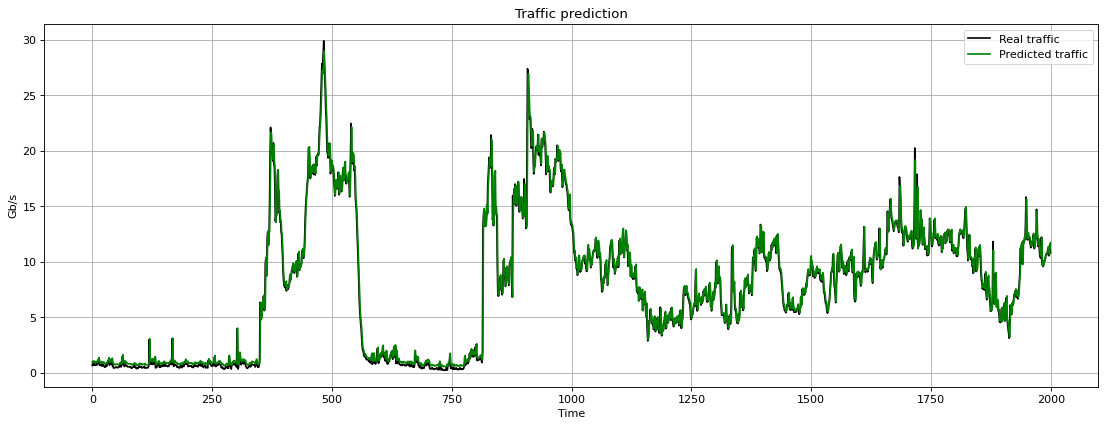

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(17, 6), dpi=80)

plt.plot(rem_test, color = 'black', label = 'Real traffic')
plt.plot(final_predicted_traf, color = 'green', label = 'Predicted traffic')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(rem_test, final_predicted_traf)

0.8309061848820152

In [ ]:
n_final_predicted_traf = (2*predicted_traf1[1:]+2*predicted_traf2[1:]+2*predicted_traf3[1:]+9*naive_pred)/15
#n_final_predicted_traf = (1*predicted_traf2[1:]+1*naive_pred)/2

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(rem_test[1:], n_final_predicted_traf)

0.8025787129013765

Downsampling

2.115590647336852

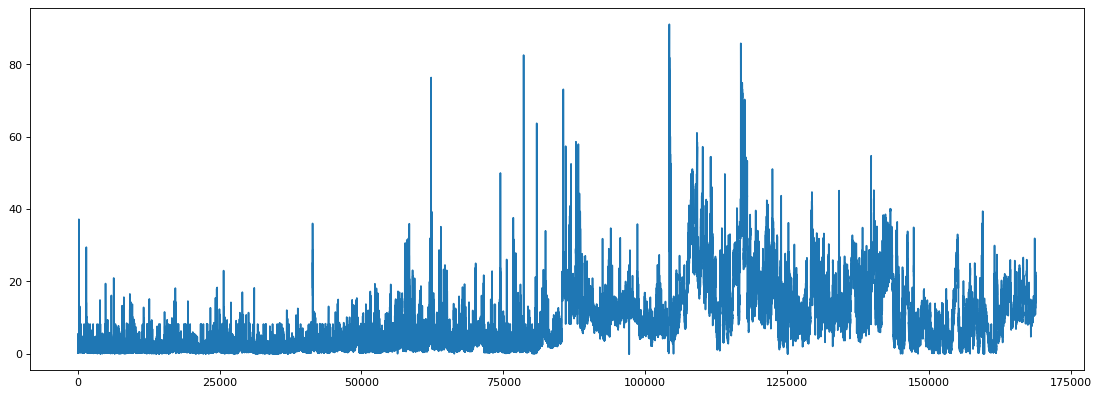

In [ ]:
figure(figsize=(17, 6), dpi=80)
plt.plot(dataset)
n_pred = dataset[:-1]
n_truth = dataset[1:]
mean_squared_error(n_truth, n_pred)

In [ ]:
cutted_dataset = dataset.iloc[::30]
cutted_dataset = cutted_dataset.reset_index()
cutted_dataset.drop(['index'], axis=1, inplace=True)
cutted_dataset

,in
0,0.272481
1,0.526493
2,2.121372
3,1.994413
4,1.054009
...,...
5625,14.869924
5626,12.244511
5627,16.621852
5628,20.159091


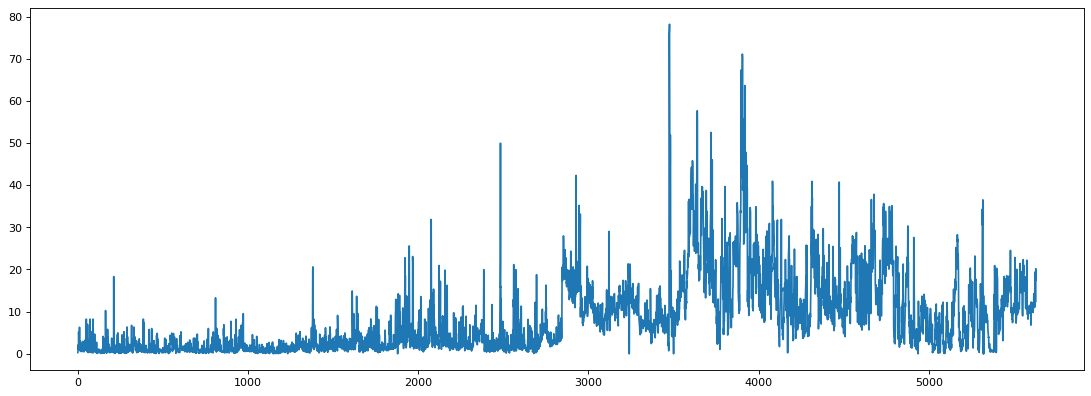

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(17, 6), dpi=80)
plt.plot(cutted_dataset)

In [ ]:
n_pred = cutted_dataset[:-1]
n_truth = cutted_dataset[1:]
mean_squared_error(n_truth, n_pred)

16.4139954067518

In [ ]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(cutted_dataset, test_size=0.1, shuffle=False)

In [ ]:
training_set = dataset_train.values
training_set = np.reshape(training_set, (-1, 1))

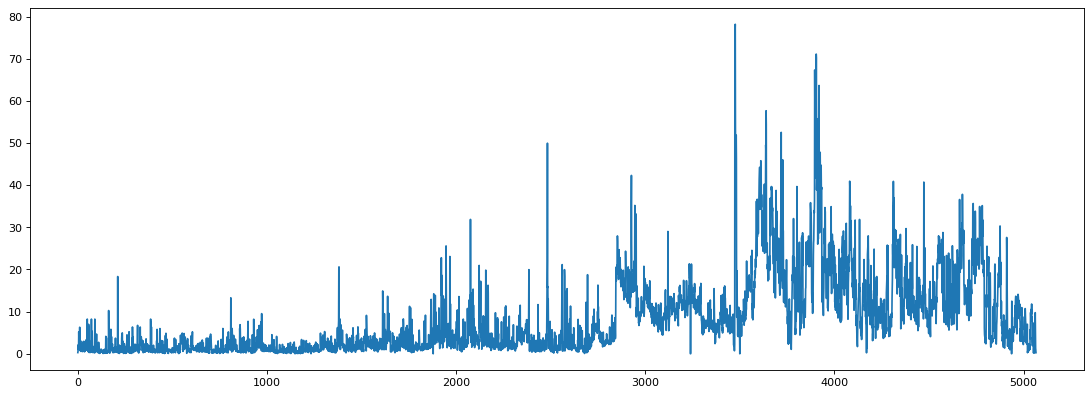

In [ ]:
figure(figsize=(17, 6), dpi=80)
plt.plot(training_set)

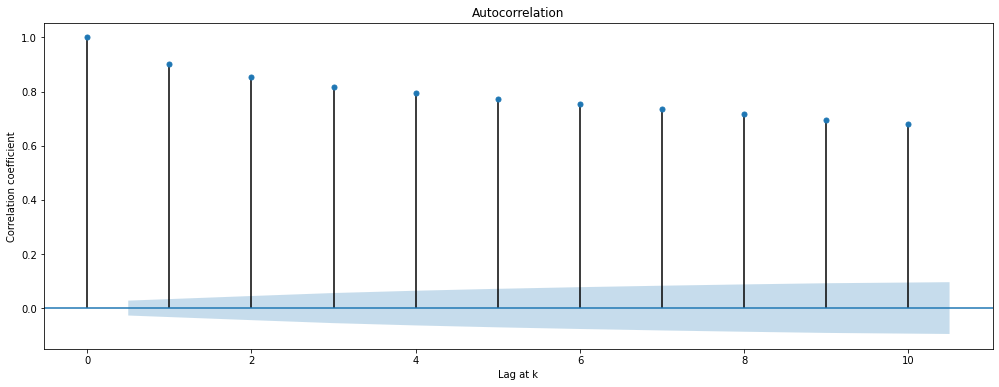

In [ ]:
from statsmodels.graphics import tsaplots
from matplotlib.pyplot import figure


with plt.rc_context():
  plt.rc("figure", figsize=(17,6))
  fig = tsaplots.plot_acf(training_set, lags=10)
  plt.xlabel("Lag at k")
  plt.ylabel("Correlation coefficient")
  plt.show()

In [ ]:
X_train = []
y_train = []
WINDOW_SIZE = 8

for i in range(WINDOW_SIZE,len(training_set)):
  X_train.append(training_set[i-WINDOW_SIZE:i, 0])
  y_train.append(training_set[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
import keras
import keras.models
import keras.layers

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    #keras.layers.Dropout(0.2),
    keras.layers.LSTM(20),
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=6)
model.fit(X_train, y_train, epochs = 120, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/120
143/143 [==============================] - 6s 15ms/step - loss: 100.8181 - val_loss: 108.8105
Epoch 2/120
143/143 [==============================] - 1s 9ms/step - loss: 62.5659 - val_loss: 75.5420
Epoch 3/120
143/143 [==============================] - 1s 9ms/step - loss: 49.2439 - val_loss: 57.5137
Epoch 4/120
143/143 [==============================] - 1s 9ms/step - loss: 41.4108 - val_loss: 46.5521
Epoch 5/120
143/143 [==============================] - 1s 9ms/step - loss: 36.1207 - val_loss: 38.3147
Epoch 6/120
143/143 [==============================] - 1s 9ms/step - loss: 32.2882 - val_loss: 33.0042
Epoch 7/120
143/143 [==============================] - 1s 9ms/step - loss: 29.3390 - val_loss: 28.8233
Epoch 8/120
143/143 [==============================] - 1s 9ms/step - loss: 27.1225 - val_loss: 26.5140
Epoch 9/120
143/143 [==============================] - 1s 9ms/step - loss: 25.3033 - val_loss: 24.6597
Epoch 10/120
143/143 [==============================] - 1s 9ms/step - 

In [ ]:
test_set = training_set[-WINDOW_SIZE:]
rem_test = dataset_test.values # remaining_test_set
rem_test = np.reshape(rem_test, (-1, 1))
test_set = np.append(test_set, rem_test)
test_set = np.reshape(test_set, (-1, 1))
X_test = []
for i in range(WINDOW_SIZE, len(test_set)):
    X_test.append(test_set[i-WINDOW_SIZE:i, 0])
  
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
predicted_traf = model.predict(X_test)

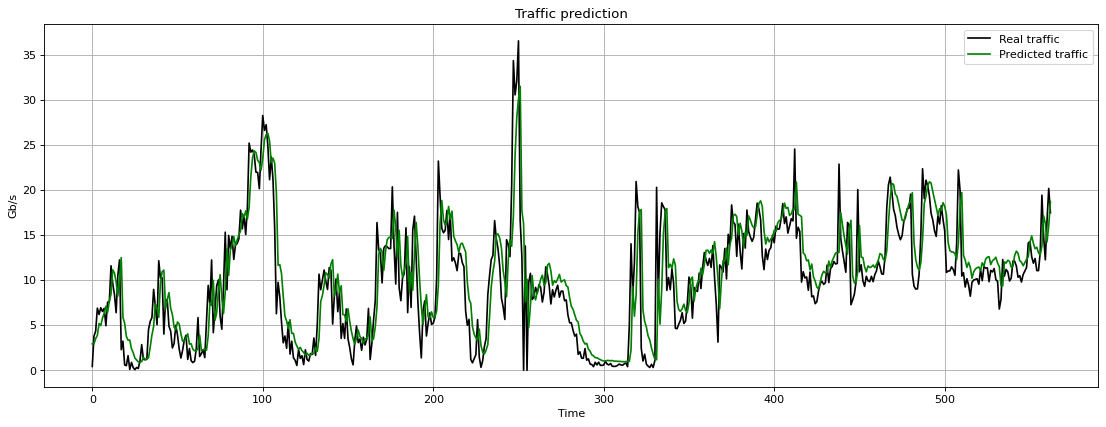

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(17, 6), dpi=80)

plt.plot(rem_test, color = 'black', label = 'Real traffic')
plt.plot(predicted_traf, color = 'green', label = 'Predicted traffic')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.grid()
plt.show()

In [ ]:
mean_squared_error(rem_test, predicted_traf)

12.812345150051017

In [ ]:
n_pred = rem_test[:-1]
n_truth = rem_test[1:]
mean_squared_error(n_truth, n_pred)

In [ ]:
predicted_traf = predicted_traf[1:]
ensemble = (predicted_traf+n_pred)/2
mean_squared_error(n_truth, ensemble)

11.599529566639598

Differentiating

In [ ]:
difference = []
for i in range(len(dataset)-1):
  difference.append(dataset[i+1] - dataset[i])

difference = pd.Series(difference)

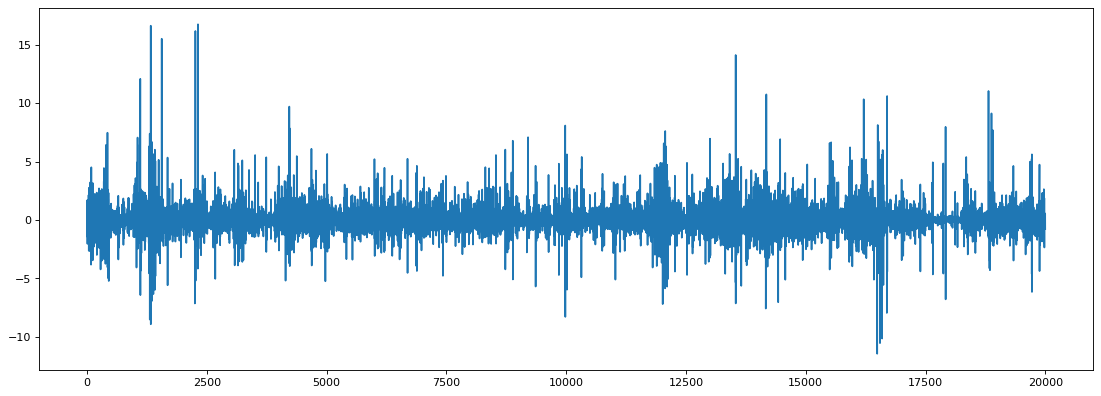

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(17, 6), dpi=80)

plt.plot(difference)

In [ ]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(difference, test_size=0.1, shuffle=False)

In [ ]:
training_set = dataset_train.values
training_set = np.reshape(training_set, (-1, 1))

In [ ]:
X_train = []
y_train = []
WINDOW_SIZE = 60

for i in range(WINDOW_SIZE,len(training_set)):
  X_train.append(training_set[i-WINDOW_SIZE:i, 0])
  y_train.append(training_set[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

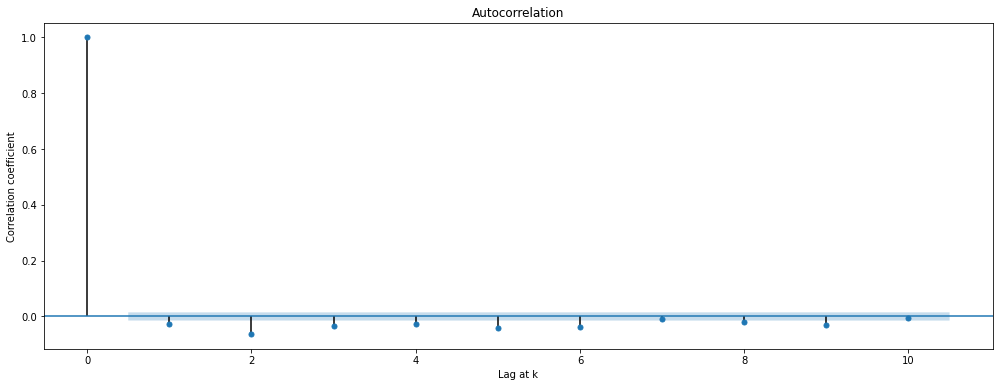

In [ ]:
from statsmodels.graphics import tsaplots
from matplotlib.pyplot import figure


with plt.rc_context():
  plt.rc("figure", figsize=(17,6))
  fig = tsaplots.plot_acf(training_set, lags=10)
  plt.xlabel("Lag at k")
  plt.ylabel("Correlation coefficient")
  plt.show()

In [ ]:
import keras
import keras.models
import keras.layers

model = keras.models.Sequential([
    keras.layers.LSTM(80, return_sequences=True, input_shape=[None, 1]),
    #keras.layers.Dropout(0.2),
    keras.layers.LSTM(80),
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=4)
model.fit(X_train, y_train, epochs = 120, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/120
349/449 [======================>.......] - ETA: 9s - loss: 1.1001

KeyboardInterrupt: ignored

In [ ]:
test_set = training_set[-WINDOW_SIZE:]
rem_test = dataset_test.values # remaining_test_set
rem_test = np.reshape(rem_test, (-1, 1))
test_set = np.append(test_set, rem_test)
test_set = np.reshape(test_set, (-1, 1))
X_test = []
for i in range(WINDOW_SIZE, len(test_set)):
    X_test.append(test_set[i-WINDOW_SIZE:i, 0])
  
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
predicted_diff = model.predict(X_test)

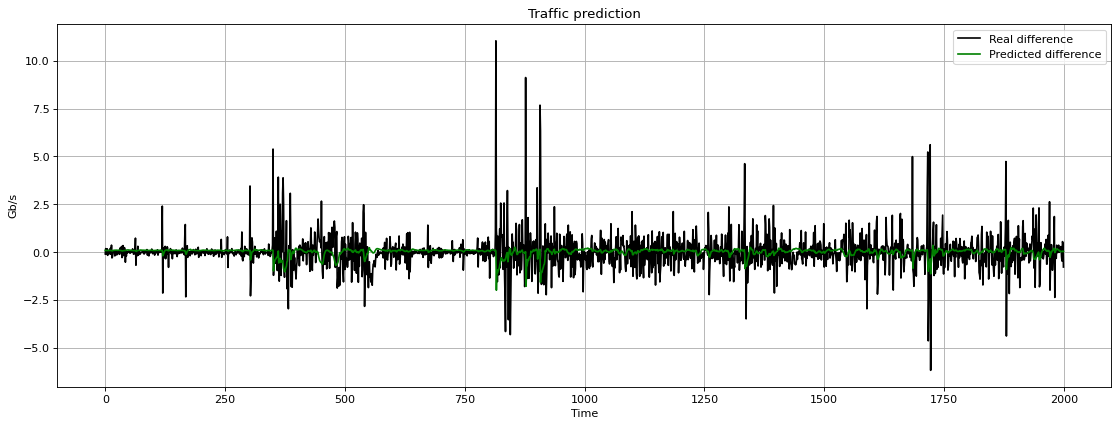

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(17, 6), dpi=80)

plt.plot(rem_test, color = 'black', label = 'Real difference')
plt.plot(predicted_diff, color = 'green', label = 'Predicted difference')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.grid()
plt.show()

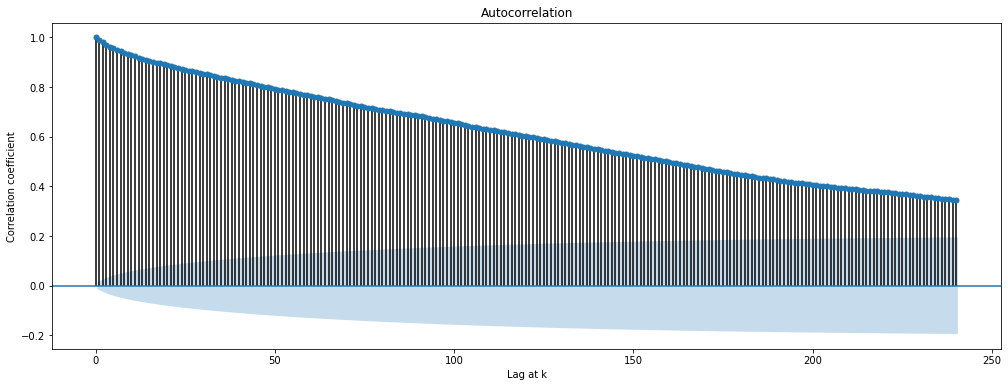

In [ ]:
from statsmodels.graphics import tsaplots
from matplotlib.pyplot import figure


with plt.rc_context():
  plt.rc("figure", figsize=(17,6))
  fig = tsaplots.plot_acf(dataset, lags=240)
  plt.xlabel("Lag at k")
  plt.ylabel("Correlation coefficient")
  plt.show()

Downsampling with mean

In [ ]:
dataset

0        0.455989
1        0.838383
2        0.965994
3        2.919324
4        4.725088
           ...   
36920    0.527621
36921    0.678641
36922    0.623023
36923    0.756997
36924    0.334998
Name: in, Length: 36925, dtype: float64

In [ ]:
mean_dataset = dataset.rolling(10).mean()
mean_dataset = mean_dataset.iloc[::10]
mean_dataset = mean_dataset[1:]
mean_dataset = mean_dataset.reset_index()
mean_dataset.drop(['index'], axis=1, inplace=True)
mean_dataset

,in
0,5.656311
1,2.477556
2,1.456650
3,5.321836
4,3.585178
...,...
3687,0.421829
3688,0.541892
3689,0.710140
3690,1.179062


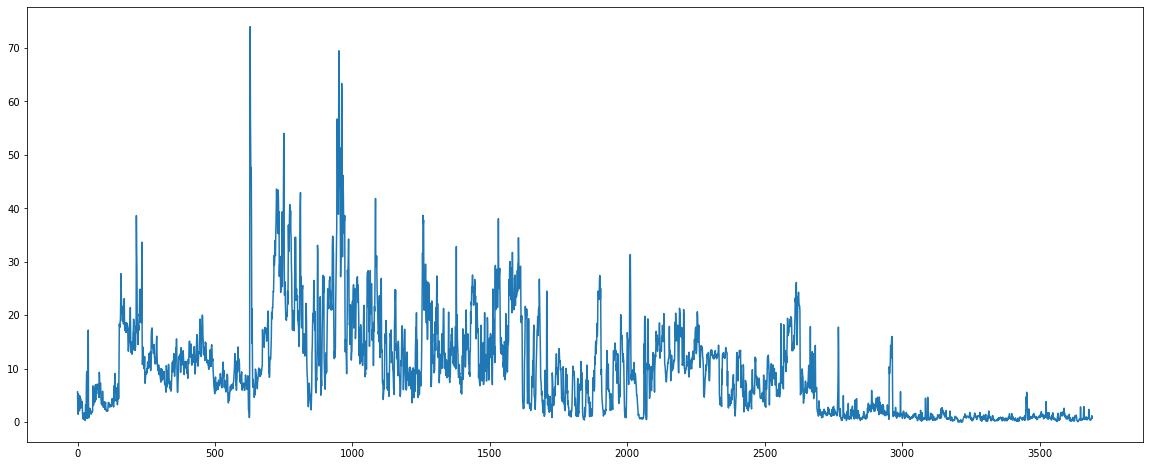

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)

plt.plot(mean_dataset)

In [ ]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(mean_dataset, test_size=0.1, shuffle=False)

training_set = dataset_train.values
training_set = np.reshape(training_set, (-1, 1))

X_train = []
y_train = []
WINDOW_SIZE = 5

for i in range(WINDOW_SIZE,len(training_set)):
  X_train.append(training_set[i-WINDOW_SIZE:i, 0])
  y_train.append(training_set[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
import keras
import keras.models
import keras.layers

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)
])

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=2)
model.fit(X_train, y_train, epochs = 120, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/120
83/83 [==============================] - 6s 21ms/step - loss: 199.7999 - val_loss: 6.0891
Epoch 2/120
83/83 [==============================] - 1s 9ms/step - loss: 122.1944 - val_loss: 20.2976
Epoch 3/120
83/83 [==============================] - 1s 9ms/step - loss: 95.3278 - val_loss: 5.8748
Epoch 4/120
83/83 [==============================] - 1s 9ms/step - loss: 79.3297 - val_loss: 2.9897
Epoch 5/120
83/83 [==============================] - 1s 9ms/step - loss: 67.8091 - val_loss: 3.5379
Epoch 6/120
83/83 [==============================] - 1s 9ms/step - loss: 59.2606 - val_loss: 4.1662


In [ ]:
test_set = training_set[-WINDOW_SIZE:]
rem_test = dataset_test.values # remaining_test_set
rem_test = np.reshape(rem_test, (-1, 1))
test_set = np.append(test_set, rem_test)
test_set = np.reshape(test_set, (-1, 1))
X_test = []
for i in range(WINDOW_SIZE, len(test_set)):
    X_test.append(test_set[i-WINDOW_SIZE:i, 0])
  
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
predicted_traf = model.predict(X_test)

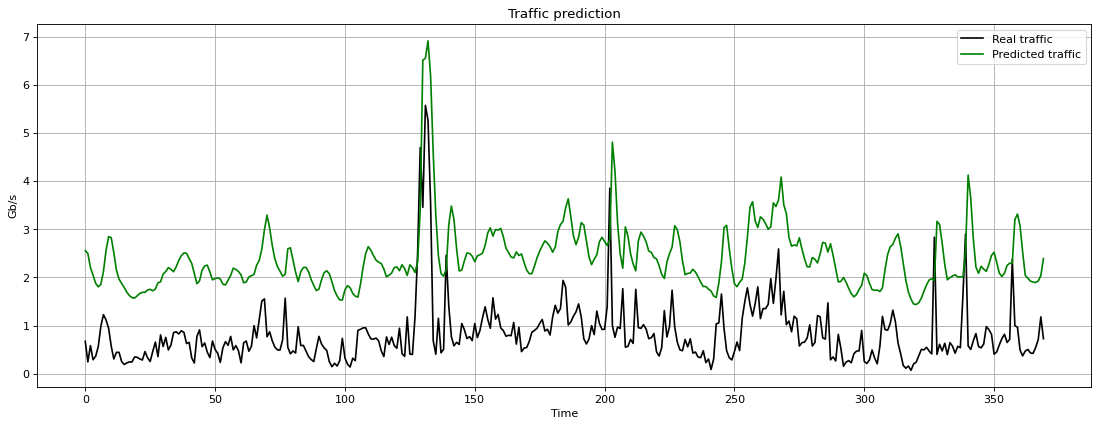

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(17, 6), dpi=80)

plt.plot(rem_test, color = 'black', label = 'Real traffic')
plt.plot(predicted_traf, color = 'green', label = 'Predicted traffic')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(rem_test, predicted_traf)

3.449565926579444

In [ ]:
n_pred = rem_test[1:]
n_truth = rem_test[:-1]

mean_squared_error(n_truth, n_pred)

2.278930742230924

In [ ]:
ma_dataset = moving_avarage_smoothing(dataset, 10)

In [ ]:
ma_dataset = pd.Series(ma_dataset)
ma_dataset

0        0.455989
1        0.647186
2        0.753455
3        1.294923
4        1.980956
           ...   
36920    0.771374
36921    0.725297
36922    0.698719
36923    0.670103
36924    0.663371
Length: 36925, dtype: float64

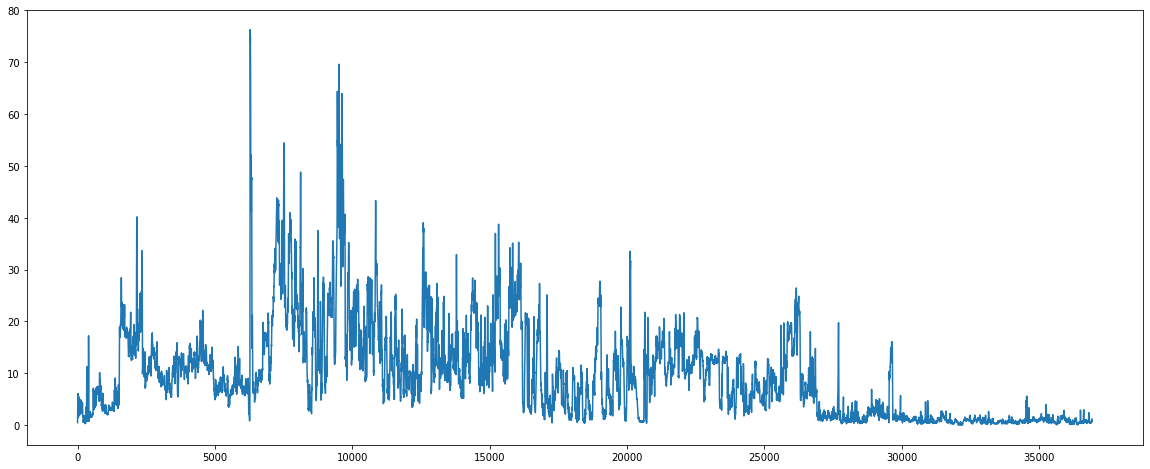

In [ ]:
plt.plot(ma_dataset)

In [ ]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(ma_dataset, test_size=0.1, shuffle=False)

training_set = dataset_train.values
training_set = np.reshape(training_set, (-1, 1))

X_train = []
y_train = []
WINDOW_SIZE = 8

for i in range(WINDOW_SIZE,len(training_set)):
  X_train.append(training_set[i-WINDOW_SIZE:i, 0])
  y_train.append(training_set[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
import keras
import keras.models
import keras.layers

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)
])

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
early_stopping = EarlyStopping(patience=2)
model.fit(X_train, y_train, epochs = 120, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/120
831/831 [==============================] - 12s 9ms/step - loss: 66.5229 - val_loss: 0.1080
Epoch 2/120
831/831 [==============================] - 7s 8ms/step - loss: 18.7425 - val_loss: 0.0659
Epoch 3/120
831/831 [==============================] - 7s 8ms/step - loss: 9.5846 - val_loss: 0.0500
Epoch 4/120
831/831 [==============================] - 7s 8ms/step - loss: 5.7227 - val_loss: 0.0621
Epoch 5/120
831/831 [==============================] - 7s 8ms/step - loss: 3.6612 - val_loss: 0.0423
Epoch 6/120
831/831 [==============================] - 7s 8ms/step - loss: 2.4605 - val_loss: 0.0409
Epoch 7/120
831/831 [==============================] - 7s 8ms/step - loss: 1.6993 - val_loss: 0.0352
Epoch 8/120
831/831 [==============================] - 7s 8ms/step - loss: 1.1950 - val_loss: 0.0348
Epoch 9/120
831/831 [==============================] - 7s 8ms/step - loss: 0.8619 - val_loss: 0.0422
Epoch 10/120
831/831 [==============================] - 7s 8ms/step - loss: 0.6221 - val

In [ ]:
test_set = training_set[-WINDOW_SIZE:]
rem_test = dataset_test.values # remaining_test_set
rem_test = np.reshape(rem_test, (-1, 1))
test_set = np.append(test_set, rem_test)
test_set = np.reshape(test_set, (-1, 1))
X_test = []
for i in range(WINDOW_SIZE, len(test_set)):
    X_test.append(test_set[i-WINDOW_SIZE:i, 0])
  
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
predicted_traf = model.predict(X_test)

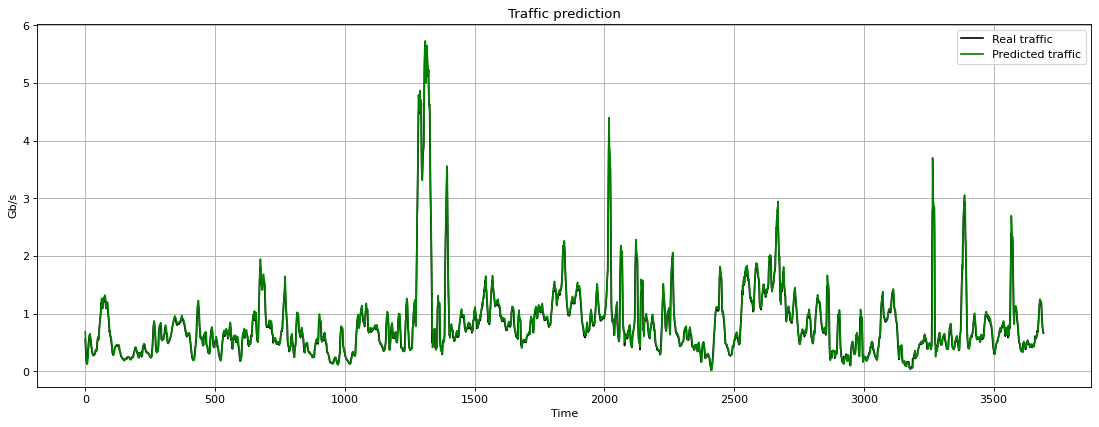

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(17, 6), dpi=80)

plt.plot(rem_test, color = 'black', label = 'Real traffic')
plt.plot(predicted_traf, color = 'green', label = 'Predicted traffic')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.grid()
plt.show()

In [ ]:
mean_squared_error(rem_test, predicted_traf)

0.007677853878347836

In [ ]:
n_pred = rem_test[1:]
n_truth = rem_test[:-1]

In [ ]:
mean_squared_error(n_truth, n_pred)

0.007673359459101871

In [ ]:
ensemble = (predicted_traf[1:]+n_pred) / 2
mean_squared_error(n_truth, ensemble)

0.003396561531252357

**Another link (periodic link)**

In [3]:
# Test the traffic download...
link = ("snla-rt1", "ae0.1155")
a, b = datetime(2021,9,1,0,0,30), datetime(2021,11,19,0,0,0)
df = download_link_traffic(link, a, b)
df = changeDateFormat(df)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

In [4]:
df['in'].fillna(np.mean(df['in']), inplace=True)
df['out'].fillna(np.mean(df['out']), inplace=True)
df['in'] = df['in']/10**9
df['out'] = df['out']/10**9

In [5]:
df_out = df['out']
df_in = df['in']

dataset = df['in']

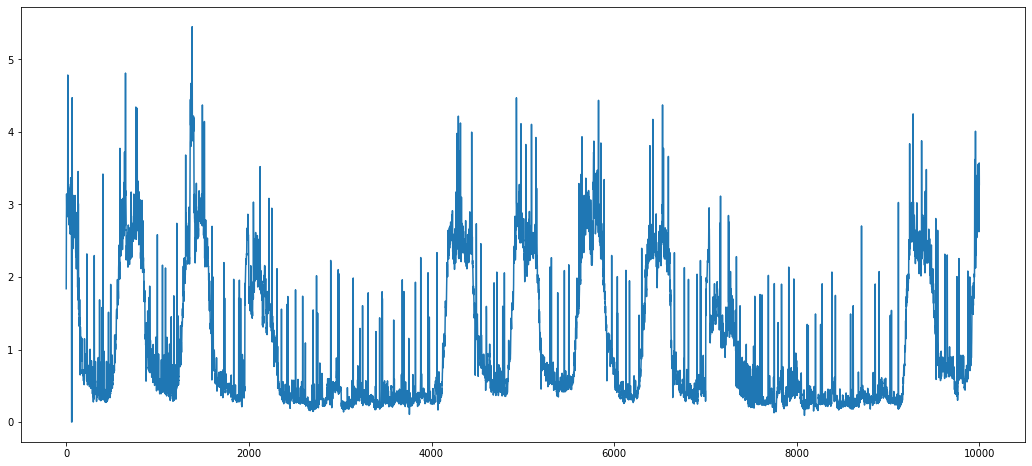

In [11]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18,8)
dataset[:10000].plot()

In [13]:
dataset

0        1.838217
1        2.569283
2        2.708931
3        2.978547
4        3.145117
           ...   
36920    1.629512
36921    1.676447
36922    1.516758
36923    1.594551
36924    0.795084
Name: in, Length: 36925, dtype: float64

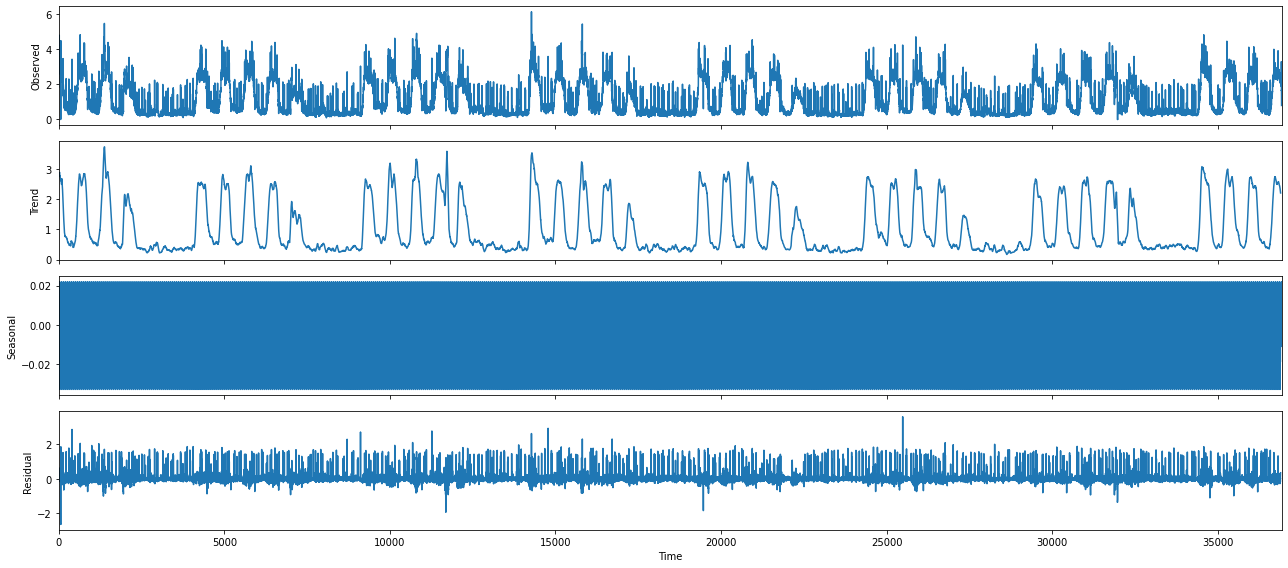

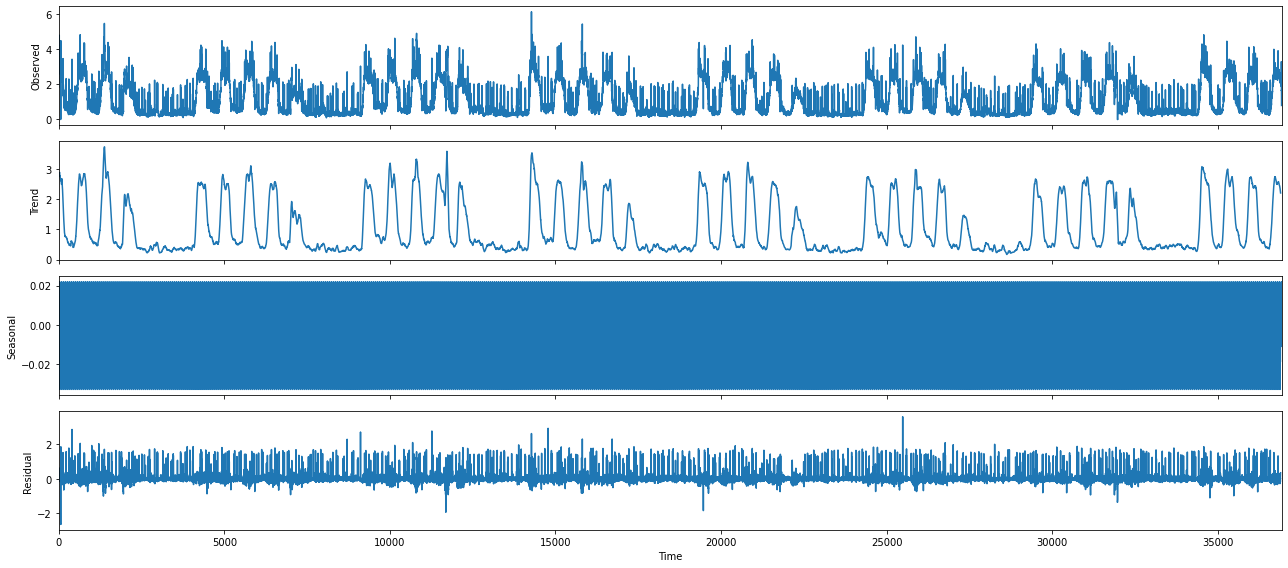

In [18]:
import statsmodels.api as sm

result = sm.tsa.seasonal_decompose(dataset.values, freq=60)
result.plot()

In [ ]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(dataset, test_size=0.1, shuffle=False)

In [ ]:
training_set = dataset_train.values
training_set = np.reshape(training_set, (-1, 1))

In [ ]:
X_train = []
y_train = []
WINDOW_SIZE = 8

for i in range(WINDOW_SIZE,len(training_set)):
  X_train.append(training_set[i-WINDOW_SIZE:i, 0])
  y_train.append(training_set[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
import keras
import keras.models
import keras.layers

model = keras.models.Sequential([
    keras.layers.LSTM(40, return_sequences=True, input_shape=[None, 1]),
    #keras.layers.Dropout(0.2),
    keras.layers.LSTM(40),
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=6)
model.fit(X_train, y_train, epochs = 120, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/120
831/831 [==============================] - 14s 12ms/step - loss: 0.0824 - val_loss: 0.0577
Epoch 2/120
831/831 [==============================] - 9s 11ms/step - loss: 0.0605 - val_loss: 0.0517
Epoch 3/120
831/831 [==============================] - 9s 11ms/step - loss: 0.0588 - val_loss: 0.0506
Epoch 4/120
831/831 [==============================] - 10s 12ms/step - loss: 0.0575 - val_loss: 0.0506
Epoch 5/120
831/831 [==============================] - 9s 11ms/step - loss: 0.0561 - val_loss: 0.0477
Epoch 6/120
831/831 [==============================] - 9s 11ms/step - loss: 0.0544 - val_loss: 0.0487
Epoch 7/120
831/831 [==============================] - 9s 11ms/step - loss: 0.0538 - val_loss: 0.0462
Epoch 8/120
831/831 [==============================] - 9s 11ms/step - loss: 0.0526 - val_loss: 0.0493
Epoch 9/120
831/831 [==============================] - 9s 11ms/step - loss: 0.0519 - val_loss: 0.0450
Epoch 10/120
831/831 [==============================] - 9s 11ms/step - loss: 0.0

In [ ]:
test_set = training_set[-WINDOW_SIZE:]
rem_test = dataset_test.values # remaining_test_set
rem_test = np.reshape(rem_test, (-1, 1))
test_set = np.append(test_set, rem_test)
test_set = np.reshape(test_set, (-1, 1))
X_test = []
for i in range(WINDOW_SIZE, len(test_set)):
    X_test.append(test_set[i-WINDOW_SIZE:i, 0])
  
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
predicted_traf = model.predict(X_test)

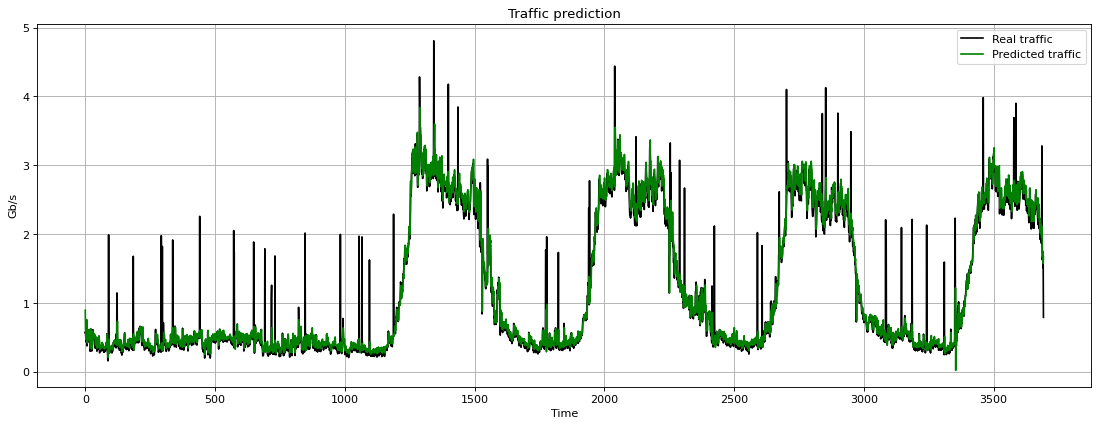

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(17, 6), dpi=80)

plt.plot(rem_test, color = 'black', label = 'Real traffic')
plt.plot(predicted_traf, color = 'green', label = 'Predicted traffic')
plt.title('Traffic prediction')
plt.xlabel('Time')
plt.ylabel('Gb/s')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(rem_test, predicted_traf)

0.04915526961648655

In [ ]:
naive_pred = rem_test[:-1]
naive_truth = rem_test[1:]

In [ ]:
mean_squared_error(naive_truth, naive_pred)

0.0785369585258313

In [ ]:
ensemble_pred = (predicted_traf[1:] + naive_pred)/2
mean_squared_error(naive_truth, ensemble_pred)

0.05614370078090181